In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
#Change the path according to where is your data 
DATA_TRAIN_PATH = r"C:\Users\Mohamed Ali\Desktop\MA1\Machine Learning\Project\Project 1\Data\train.csv" 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [3]:
### Define variables for the dimensions of the data
N = tX.shape[0]
D = tX.shape[1]

# Data Pre-Processing

In [4]:
### Transform tX by changing -999 with the mean of column
def transformTX(tX):
    tX2 = np.copy(tX)
    tX2[tX2 == -999] = 0
    means = np.mean(tX2, axis=0)
    for i in range(N):
        for j in range(D):
            if tX[i][j] == -999:
                tX[i][j] = means[j]
    return tX

In [5]:
### Apply log to smoothen data
def maybeAddLog(tX):
    tX2 = np.copy(tX)
    mins = np.min(tX2, axis=0)
    for i in range(D):
        if mins[i]>0:
            for k in range(N):
                tX[k][i] = np.log(tX[k][i])
    return tX

In [6]:
### Features Expansion to capture non linear data
def featuresExpansion(tX, degree):
    res = np.zeros(N).reshape(-1,1)
    for i in range(D):
        for d in range(1,degree+1):
            col = tX[:,i]**d
            col = col.reshape(-1,1)
            res = np.hstack((res, col))
    res = np.delete(res, 0,1)
    return res

In [7]:
deg = 6
tX = transformTX(tX)
tX = maybeAddLog(tX)
tX = featuresExpansion(tX, deg)

# Linear Regression

Remark: We are assuming that we DO NOT have an offset and that w = {w1, w2, ... , wD} where D=30 in our case

In [8]:
### Helper function to select a small set of data (Given in lab2)
def batch_iter(y, tx, batch_size, num_batches=1, shuffle=True):
    """
    Generate a minibatch iterator for a dataset.
    Takes as input two iterables (here the output desired values 'y' and the input data 'tx')
    Outputs an iterator which gives mini-batches of `batch_size` matching elements from `y` and `tx`.
    Data can be randomly shuffled to avoid ordering in the original data messing with the randomness of the minibatches.
    """
    data_size = len(y)

    if shuffle:
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_y = y[shuffle_indices]
        shuffled_tx = tx[shuffle_indices]
    else:
        shuffled_y = y
        shuffled_tx = tx
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        if start_index != end_index:
            yield shuffled_y[start_index:end_index], shuffled_tx[start_index:end_index]

In [9]:
### Loss function that we use (this function is not used directly but only its gradient)
def compute_loss_lin(y, tX, w):
    #Calculate the loss using mse
    
    e = y - (tX @ w)
    return (1/(2*tX.shape[0])) * (e.T @ e)

In [10]:
### Compute the gradient
def compute_gradient_lin(y, tX, w):
    e = y - (tX @ w)
    return (-1/tX.shape[0]) * (tX.T @ e)

In [11]:
### Gradient descent algorithm: the function returns best w
def least_squares_GD(y, tX, initial_w, max_iters, gamma):
    w = initial_w
    for _ in range(max_iters):
        grad = compute_gradient_lin(y,tX,w)
        w = w - gamma * grad
    return w

In [12]:
batch_size_linear = 1

In [13]:
### Stochastic gradient descent algorithm: the function returns best w
def least_squares_SGD(y, tX, initial_w, max_iters, gamma):
    iterate = next(batch_iter(y, tX, batch_size_linear, num_batches=1, shuffle=True))
    y1 = iterate[0]
    tX1 = iterate[1]
    w = initial_w
    for n_iter in range(max_iters):
        grad = compute_gradient_lin(y1,tX1,w)
        w = w - gamma * grad
    return w

In [14]:
### Least squares regression using normal equations
def least_squares(y, tX):
    return np.linalg.solve(tX.T@tX,tX.T@y)

# Ridge Regression

In [15]:
### Ridge regression using normal equations 
def ridge_regression(y, tx, lambda_):
    lambda_prime = 2 * tx.shape[0] * lambda_
    identity = np.eye(tx.shape[1])
    LHS = (tx.T@tx) + lambda_prime*identity
    RHS = tx.T@y
    
    return np.linalg.solve(LHS, RHS)

# Logistic Regression

In [16]:
### Helper function to compute sigmoid
def sigmoid(t):
    """apply sigmoid function on t."""
    return 1.0 / (1 + np.exp(-t))

In [17]:
def compute_logistic_loss(y, tx, w):
    """compute the cost by negative log likelihood."""
    val = y.T @ np.log(sigmoid(tx@w)) + (1-y.T) @ np.log(1-sigmoid(tx@w))
    return np.squeeze(- val)

In [18]:
### Compute the gradient of  
def compute_gradient_log(y, tx, w):
    return tx.T @ (sigmoid(tx@w) - y)

In [19]:
### Logistic regression using gradient descent
def logistic_regression_GD(y, tx, initial_w, max_iters, gamma):
    w = initial_w
    for _ in range(max_iters):
        gradient = compute_gradient_log(y, tx, w)
        w = w - gamma * gradient
    
    return w

In [20]:
batch_size_log = 1

In [21]:
### Logisitic regression using stochastic gradient descent 
def logistic_regression_SGD(y, tx, initial_w, max_iters, gamma):
    iterate = next(batch_iter(y, tx, batch_size_log, num_batches=1, shuffle=True))
    y1 = iterate[0]
    tx1 = iterate[1]
    w = initial_w
    
    for _ in range(max_iters):
        gradient = compute_gradient_log(y1, tx1, w)
        w = w - gamma * gradient
        
    return w    

# Regularized Logistic Regression

In [22]:
### Compute regularized gradient
def compute_gradient_reg(y, tx, w, lambda_):
    return compute_gradient_log(y, tx, w) + lambda_*w

In [23]:
### Regularized Logistic regression using gradient descent
def reg_logistic_regression_GD(y, tx, lambda_, initial_w, max_iters, gamma):
    w = initial_w
    for _ in range(max_iters):
        gradient = compute_gradient_reg(y, tx, w, lambda_)
        w = w - gamma * gradient
    return w

In [24]:
batch_size_reg = 1

In [25]:
### Regularized Logisitic regression using stochastic gradient descent 
def reg_logistic_regression_SGD(y, tx, lambda_, initial_w, max_iters, gamma):
    iterate = next(batch_iter(t, tx, batch_size_reg, num_batches=1, shuffle=True))
    y1 = iterate[0]
    tx1 = iterate[1]
    w = initial_w
    
    for _ in range(max_iters):
        gradient = compute_gradient_reg(y1, tx1, w, lambda_)
        w = w - gamma * gradient
        
    return w 

# Prediction logistic regression

In [26]:
def predict_labels_logistic(weights, data):
    """Generates class predictions given weights, and a test data matrix on a logistic regression"""
    y_pred = np.dot(data, weights)
    for i in range(len(y_pred)):
        y_pred[i] = sigmoid(y_pred[i])
    y_pred[np.where(y_pred < 0.5)] = -1
    y_pred[np.where(y_pred >= 0.5)] = 1
    
    return y_pred

# Cross validation

In [27]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = N
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

In [28]:
def cross_validation(y, x, k_indices, k, lambda_, degree):
    """return the loss of ridge regression."""
    # get k'th subgroup in test, others in train
    te_indice = k_indices[k]
    tr_indice = k_indices[~(np.arange(k_indices.shape[0]) == k)]
    tr_indice = tr_indice.reshape(-1)
    y_te = y[te_indice]
    y_tr = y[tr_indice]
    x_te = x[te_indice]
    x_tr = x[tr_indice]
    
    # ridge regression
    w = ridge_regression(y_tr, x_tr, lambda_)
    
    # Linear GD
    #w = least_squares_GD(y_tr, x_tr, np.zeros(x_tr.shape[1]), 500, lambda_)
    y_pred_tr = predict_labels(w, x_tr) 
    y_pred_te = predict_labels(w, x_te)
    # Compare y_pred with y_te
    acc_tr = 0
    acc_te = 0
    for i in range(y_tr.shape[0]):
        if y_tr[i] == y_pred_tr[i]:
            acc_tr += 1
    acc_tr = acc_tr/y_tr.shape[0]
    for i in range(y_te.shape[0]):
        if y_te[i] == y_pred_te[i]:
            acc_te += 1
    acc_te = acc_te/y_te.shape[0]
    
    return acc_tr, acc_te, w

In [29]:
### Defining variables
seed = 6 
k_fold = 4
lambdas = np.logspace(-4, 0, 30)

In [30]:
degree=6

0.8043359999999999


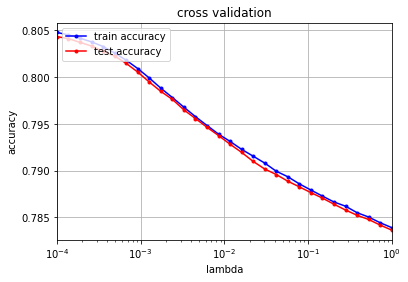

In [31]:
from plots import cross_validation_visualization

def cross_validation_demo():
    # split data in k fold
    k_indices = build_k_indices(y, k_fold, seed)
    
    # define lists to store the loss of training data and test data
    mean_acc_tr = []
    mean_acc_te = []
    
    # cross validation
    for lambda_ in lambdas:
        mean_acc_tr_tmp = []
        mean_acc_te_tmp = []
        
        for k in range(k_fold):
            acc_tr, acc_te,_ = cross_validation(y, tX, k_indices, k, lambda_, degree)
            mean_acc_tr_tmp.append(acc_tr)
            mean_acc_te_tmp.append(acc_te)
        mean_acc_tr.append(np.mean(mean_acc_tr_tmp))
        mean_acc_te.append(np.mean(mean_acc_te_tmp))
    print(max(mean_acc_te))
    cross_validation_visualization(lambdas, mean_acc_tr, mean_acc_te)
    
cross_validation_demo()

# Generate predictions and save ouput in csv format for submission:

In [32]:
DATA_TEST_PATH = r"C:\Users\Mohamed Ali\Desktop\MA1\Machine Learning\Project\Project 1\Data\test.csv" # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [33]:
OUTPUT_PATH = r'C:\Users\USER\Desktop\MA1\ML\output.csv' # TODO: fill in desired name of output file for submission

In [35]:
tX_test = transformTX(tX_test)
tX_test = maybeAddLog(tX_test)
tX_test = featuresExpansion(tX_test, deg)


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 250000 and the array at index 1 has size 568238

In [ ]:
print(y.shape)
print(tX.shape)

In [ ]:
###IF WE ARE USING LEAST_SQUARES 
weights = least_squares(y,tX)
y_pred = predict_labels(weights, tX_test)

In [ ]:
###IF WE ARE USING LOGISTIC REGRESSION
y[y == -1] = 0  #We set y's where it is -1 to 0 in order to work with probabilities
initial_w = np.random.randint(-1000, 1000, D)
max_iters = 1000
gamma = 1e-10
weights = logistic_regression_GD(y, tX, initial_w, max_iters, gamma)
y_pred = predict_labels_logistic(weights, tX_test)

In [ ]:
#Create submission
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)